In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, Operator, SparsePauliOp
from qiskit.visualization import plot_histogram
from scipy.linalg import expm
import matplotlib.pyplot as plt

token = "_CPmpnD8X0jvJZQZ76vEU1sZKMiUa_im5IoRTHWVTTYx"
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud",
  overwrite=True,
  instance=""
)

In [ ]:
M = np.array([[1, 0, 8, 1],
              [0, 1, 1, 8],
              [8, 1, 1, 0],
              [1, 8, 0, 1]], dtype=complex)

pauli_labels = ['II', 'IX', 'IY', 'IZ',
                'XI', 'XX', 'XY', 'XZ',
                'YI', 'YX', 'YY', 'YZ',
                'ZI', 'ZX', 'ZY', 'ZZ']

coeffs = []
for label in pauli_labels:
    P = Pauli(label)
    op = Operator(P)
    coeff = 0.25 * np.trace(op.data.conj().T @ M)  
    coeffs.append(coeff)

for label, c in zip(pauli_labels, coeffs):
    if not np.isclose(c, 0):
        print(f"{label}: {c.real:.3f} + {c.imag:.3f}j")

II: 1.000 + 0.000j
XI: 8.000 + 0.000j
XX: 1.000 + 0.000j


## built-in expm 활용하기

C:\Users\Goseumdochy\AppData\Local\Temp\ipykernel_1160\1601524607.py:41: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_ancilla, inverse=True, do_swaps=True),


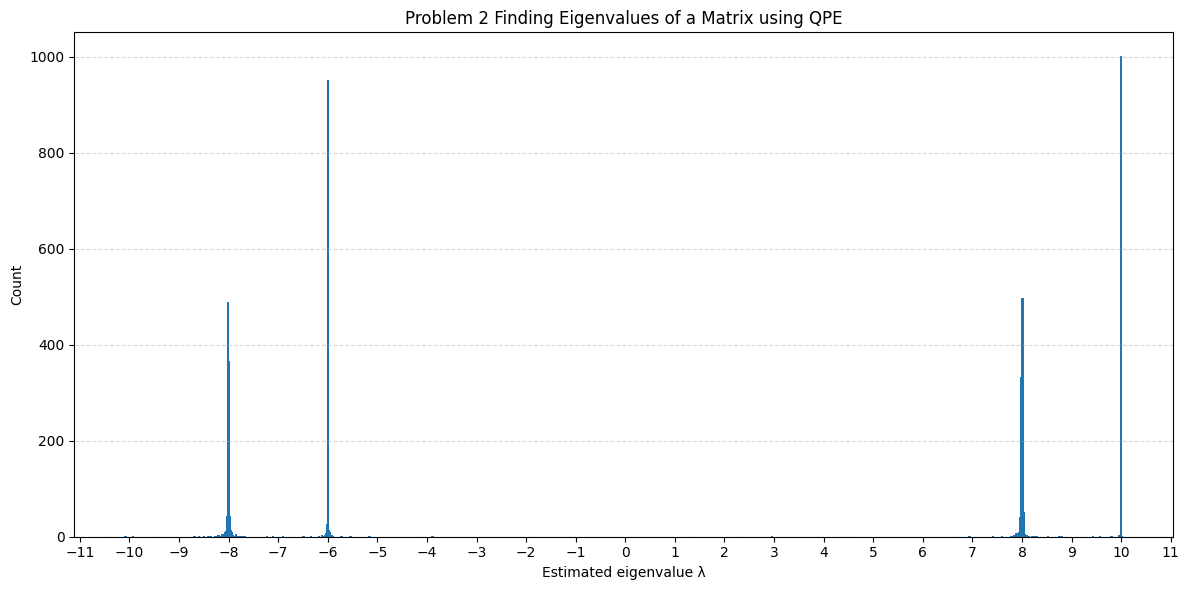

In [ ]:
X = np.array([[0, 1], [1, 0]], dtype=complex)
I = np.eye(2, dtype=complex)
XI = np.kron(X, I)
XX = np.kron(X, X)
II = np.kron(I, I)

M = 8 * XI + 1 * XX + 1 * II

norm_1 = np.max(np.sum(np.abs(M), axis=0)) + 0.1
norm_inf = np.max(np.sum(np.abs(M), axis=1)) + 0.1

norm_bound = min(norm_1, norm_inf)

A = (np.eye(4) + M / norm_bound) / 2

t = 2 * np.pi
UA = expm(1j * A * t)
U_gate = UnitaryGate(UA, label="e^{-iAt}")
cU_gate = U_gate.control(1)

backend = AerSimulator()
shots = 1024
num_ancilla = 10
all_counts = {}

for basis in range(4):
    qc = QuantumCircuit(num_ancilla + 2, num_ancilla)
    qc.h(range(num_ancilla))

    if basis & 1: qc.x(num_ancilla + 1)
    if basis & 2: qc.x(num_ancilla)

    for j in range(num_ancilla):
        qc.append(cU_gate.power(2**j),
                  [j, num_ancilla, num_ancilla + 1])

    qc.append(QFT(num_ancilla, inverse=True, do_swaps=True),
              range(num_ancilla))
    qc.measure(range(num_ancilla), range(num_ancilla))

    job = backend.run(transpile(qc, backend), shots=shots)
    counts = job.result().get_counts()
    for bitstr, cnt in counts.items():
        all_counts[bitstr] = all_counts.get(bitstr, 0) + cnt

plot_histogram(
    all_counts,
    title="Scaled-QPE using Pauli-Decomposed M",
    figsize=(12, 6)
)

bin_width = 0.05
lam_bins = {}

for bitstr, count in all_counts.items():
    k = int(bitstr, 2)
    alpha = k / (2 ** num_ancilla)
    lam = norm_bound * (2 * alpha - 1)
    lam_bins[lam] = lam_bins.get(lam, 0) + count

x_vals = sorted(lam_bins.keys())
y_vals = [lam_bins[x] for x in x_vals]

plt.figure(figsize=(12, 6))
plt.bar(x_vals, y_vals, width=bin_width * 0.9)
plt.xlabel("Estimated eigenvalue λ")
plt.ylabel("Count")
plt.title("Problem 2 Finding Eigenvalues of a Matrix using QPE")

xmin = int(np.floor(min(x_vals)))
xmax = int(np.ceil(max(x_vals)))
plt.xticks(np.arange(xmin, xmax + 1, 1))

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## built-in expm 활용하지 않고 직접 decomposition 하연 구현하기

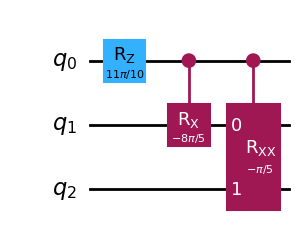

C:\Users\Goseumdochy\AppData\Local\Temp\ipykernel_1160\23362177.py:46: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_ancilla, inverse=True, do_swaps=True),


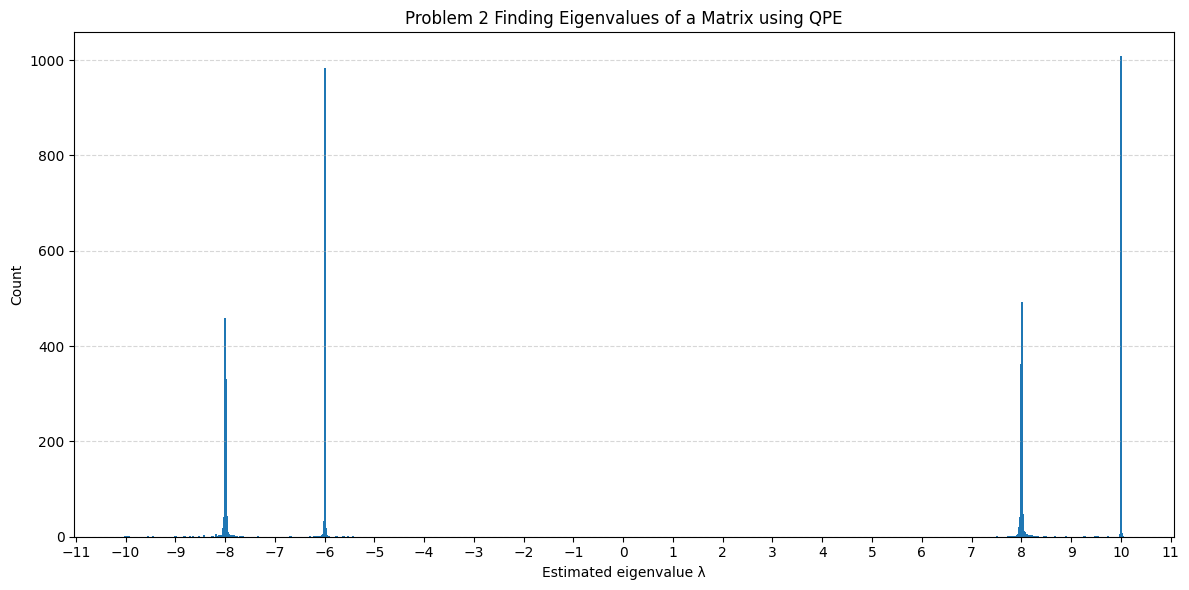

In [ ]:
from qiskit.circuit.library import RXXGate

norm_1 = np.max(np.sum(np.abs(M), axis=0)) + 0.1
norm_inf = np.max(np.sum(np.abs(M), axis=1)) + 0.1

norm_bound = min(norm_1, norm_inf)

A = (np.eye(4) + M / norm_bound) / 2

def build_exp_iAt(norm_bound):
    theta_xi = -2*np.pi * 8 / norm_bound
    theta_xx = -2*np.pi * 1 / norm_bound
    theta_ii = np.pi * ((1 / norm_bound) + 1)

    qc = QuantumCircuit(3)
    qc.rz(theta_ii, 0)
    qc.crx(theta_xi, 0, 1)
    qc.append(RXXGate(theta_xx).control(1), [0, 1, 2])

    return qc

display(build_exp_iAt(10).draw('mpl'))

t = 2 * np.pi
cU_gate = build_exp_iAt(norm_bound).to_gate()

backend = AerSimulator()
shots = 1024
num_ancilla = 10
all_counts = {}

for basis in range(4):
    qc = QuantumCircuit(num_ancilla + 2, num_ancilla)
    qc.h(range(num_ancilla))

    if basis & 1: qc.x(num_ancilla + 1)
    if basis & 2: qc.x(num_ancilla)

    for j in range(num_ancilla):
        qc.append(cU_gate.power(2**j),
                  [j, num_ancilla, num_ancilla + 1])

    qc.append(QFT(num_ancilla, inverse=True, do_swaps=True),
              range(num_ancilla))
    qc.measure(range(num_ancilla), range(num_ancilla))

    job = backend.run(transpile(qc, backend), shots=shots)
    counts = job.result().get_counts()
    for bitstr, cnt in counts.items():
        all_counts[bitstr] = all_counts.get(bitstr, 0) + cnt

plot_histogram(
    all_counts,
    title="Scaled-QPE using Pauli-Decomposed M",
    figsize=(12, 6)
)

bin_width = 0.05
lam_bins = {}

for bitstr, count in all_counts.items():
    k = int(bitstr, 2)
    alpha = k / (2 ** num_ancilla)
    lam = norm_bound * (2 * alpha - 1)
    lam_bins[lam] = lam_bins.get(lam, 0) + count

x_vals = sorted(lam_bins.keys())
y_vals = [lam_bins[x] for x in x_vals]

plt.figure(figsize=(12, 6))
plt.bar(x_vals, y_vals, width=bin_width * 0.9)
plt.xlabel("Estimated eigenvalue λ")
plt.ylabel("Count")
plt.title("Problem 2 Finding Eigenvalues of a Matrix using QPE")

xmin = int(np.floor(min(x_vals)))
xmax = int(np.ceil(max(x_vals)))
plt.xticks(np.arange(xmin, xmax + 1, 1))

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Real backend에서 실행

=== non-zero Pauli terms ===
II: +1.000+0.000j
XI: +8.000+0.000j
XX: +1.000+0.000j
◎ Real backend = ibm_aachen (156 qubits)


C:\Users\82108\AppData\Local\Temp\ipykernel_35400\79524707.py:82: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_anc, inverse=True, do_swaps=True),
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (C:\Users\82108\anaconda3\envs\qhack25\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (C:\Users\82108\anaconda3\envs\qhack25\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (C:\Users\82108\anaconda3\envs\qhack25\Lib\site-packages\qiskit\providers\__init__.py)
ERR

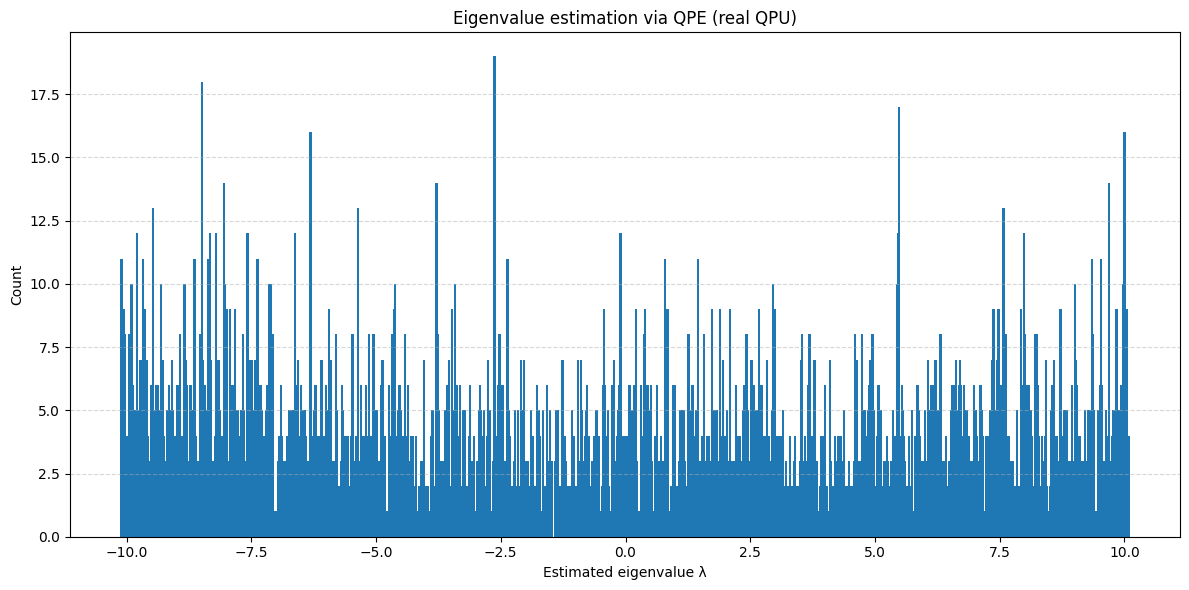

In [ ]:
import numpy as np, matplotlib.pyplot as plt, math
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Operator
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.linalg import expm

from qiskit_ibm_runtime import QiskitRuntimeService
try:                                    
    from qiskit_ibm_runtime import SamplerV2 as Sampler
except ImportError:
    from qiskit_ibm_runtime import Sampler

M = np.array([[1, 0, 8, 1],
              [0, 1, 1, 8],
              [8, 1, 1, 0],
              [1, 8, 0, 1]], dtype=complex)

pauli_labels = ['II','IX','IY','IZ','XI','XX','XY','XZ',
                'YI','YX','YY','YZ','ZI','ZX','ZY','ZZ']

coeffs = []
for lbl in pauli_labels:
    op = Operator(Pauli(lbl))
    coeffs.append(0.25 * np.trace(op.data.conj().T @ M))

print("=== non-zero Pauli terms ===")
for lbl, c in zip(pauli_labels, coeffs):
    if not np.isclose(c, 0):
        print(f"{lbl}: {c.real:+.3f}{c.imag:+.3f}j")

X  = np.array([[0,1],[1,0]], dtype=complex)
I2 = np.eye(2, dtype=complex)
XI = np.kron(X, I2);  XX = np.kron(X, X);  II = np.kron(I2, I2)

M  = 8*XI + 1*XX + 1*II
norm_bound = min(np.max(np.sum(abs(M), axis=0)),
                 np.max(np.sum(abs(M), axis=1))) + 0.1
A  = (np.eye(4) + M / norm_bound) / 2
t  = 2*math.pi
UA = expm(1j*A*t)

U_gate  = UnitaryGate(UA, label="e^{-iAt}")
cU_gate = U_gate.control(1)             

service  = QiskitRuntimeService()                          
backend  = service.least_busy(simulator=False, operational=True)               
print(f"◎ Real backend = {backend.name} ({backend.num_qubits} qubits)")

sampler  = Sampler(backend)
shots    = 1024
num_anc  = 10
all_counts = {}

for basis in range(4):
    qc = QuantumCircuit(num_anc + 2, num_anc)
    qc.h(range(num_anc))

    if basis & 1: qc.x(num_anc + 1)    
    if basis & 2: qc.x(num_anc)         

    for j in range(num_anc):
        qc.append(cU_gate.power(2**j),
                  [j, num_anc, num_anc + 1])

    qc.append(QFT(num_anc, inverse=True, do_swaps=True),
              range(num_anc))
    qc.measure(range(num_anc), range(num_anc))

    isa = generate_preset_pass_manager(
            backend=backend, optimization_level=1).run(qc)

    job = sampler.run([isa], shots=shots)
    pub = job.result()[0]
    counts = pub.join_data().get_counts()

    for bitstr, cnt in counts.items():
        all_counts[bitstr] = all_counts.get(bitstr, 0) + cnt

from qiskit.visualization import plot_histogram
plot_histogram(all_counts,
               title="Scaled-QPE using Pauli-Decomposed M",
               figsize=(12,5))

lam_bins = {}
for bitstr, cnt in all_counts.items():
    k      = int(bitstr, 2)
    alpha  = k / (2**num_anc)
    lam    = norm_bound * (2*alpha - 1)
    lam_bins[lam] = lam_bins.get(lam, 0) + cnt

xs = sorted(lam_bins.keys())
ys = [lam_bins[x] for x in xs]

plt.figure(figsize=(12,6))
plt.bar(xs, ys, width=0.05*0.9)
plt.xlabel("Estimated eigenvalue λ")    
plt.ylabel("Count")
plt.title("Eigenvalue estimation via QPE (real QPU)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
